In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

/tmp/ipykernel_2965854/3199281186.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


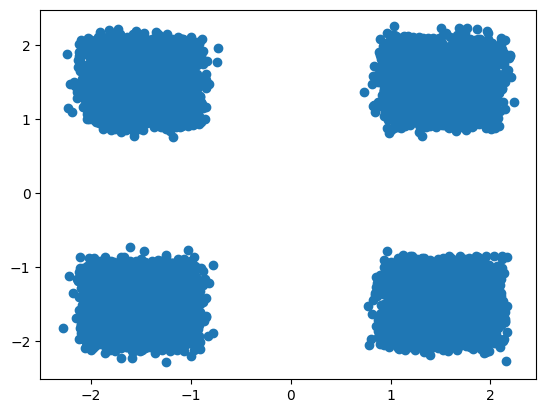

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


def generate_8gaussians_samples(num_samples):
    z = torch.randn(num_samples, 2)
    scale = 4
    sq2 = 1 / np.sqrt(2)
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (sq2, sq2),
        (-sq2, sq2),
        (sq2, -sq2),
        (-sq2, -sq2),
    ]
    centers = torch.tensor([(scale * x, scale * y) for x, y in centers])
    return (sq2 * (0.1 * z + centers[torch.randint(len(centers), size=(num_samples,))])).float()


def generate_2spiral_samples(num_samples):
    z = torch.randn(num_samples, 2)
    n = torch.sqrt(torch.rand(num_samples // 2)) * 540 * (2 * np.pi) / 360
    d1x = -torch.cos(n) * n + torch.rand(num_samples // 2) * 0.5
    d1y = torch.sin(n) * n + torch.rand(num_samples // 2) * 0.5
    x = torch.cat([torch.stack([d1x, d1y], dim=1), torch.stack([-d1x, -d1y], dim=1)], dim=0) / 3
    return (x + 0.1 * z).float()


def generate_4square_samples(num_samples):
    points_per_square = num_samples // 4
    centers = torch.tensor(
        [
            [-1.5, 1.5],  # top left
            [1.5, 1.5],  # top right
            [-1.5, -1.5],  # bottom left
            [1.5, -1.5],  # bottom right
        ]
    )

    # Fixed parameters
    square_size = 1.0
    noise = 0.1
    points = []

    for center in centers:
        x = torch.empty(points_per_square).uniform_(
            center[0] - square_size / 2, center[0] + square_size / 2
        )
        y = torch.empty(points_per_square).uniform_(
            center[1] - square_size / 2, center[1] + square_size / 2
        )

        x += torch.randn(points_per_square) * noise
        y += torch.randn(points_per_square) * noise

        points.append(torch.stack([x, y], dim=1))

    # Combine all points
    points = torch.cat(points, dim=0)

    return points


test_samples = generate_4square_samples(10000)
plt.scatter(test_samples[:, 0], test_samples[:, 1])
plt.show()

In [3]:
train_data = DataLoader(
    TensorDataset(generate_4square_samples(10000)), batch_size=32, shuffle=True
)
test_data = DataLoader(TensorDataset(generate_4square_samples(1000)), batch_size=32, shuffle=True)

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [5]:
def sample_langevin(x, model, stepsize, n_steps, noise_scale=None):
    if noise_scale is None:
        noise_scale = np.sqrt(stepsize * 2)

    x = x.detach().requires_grad_(True)

    for _ in range(n_steps):
        energy = model(x)
        grad = torch.autograd.grad(energy.sum(), x)[0]

        # Normalize gradients to prevent extreme steps
        grad_norm = torch.norm(grad, dim=-1, keepdim=True)
        grad = grad / (grad_norm + 1e-6)

        # Add noise first, then take gradient step
        noise = torch.randn_like(x) * noise_scale
        x = x - stepsize * grad + noise
        x = x.detach().requires_grad_(True)

    return x.detach()

In [6]:
def sample_hmc(x, model, n_steps, step_size=0.01, leapfrog_steps=10, mass=1.0):
    """
    Hamiltonian Monte Carlo sampling
    Args:
        x: Initial points
        model: Energy model
        n_steps: Number of HMC iterations
        step_size: Size of leapfrog steps
        leapfrog_steps: Number of leapfrog steps per iteration
        mass: Mass matrix (scalar or diagonal)
    """
    x = x.detach().requires_grad_(True)

    for _ in range(n_steps):
        # Sample momentum from kinetic energy distribution
        momentum = torch.randn_like(x) * np.sqrt(mass)

        # Store initial momentum for Metropolis correction
        init_momentum = momentum.clone()

        # Get initial energy
        init_energy = model(x).squeeze()  # Make sure energy is 1D
        init_kinetic = 0.5 * (momentum**2 / mass).sum(1)

        # Current position and momentum
        current_x = x
        current_momentum = momentum

        # Leapfrog integration
        for _ in range(leapfrog_steps):
            # Half step for momentum
            energy = model(current_x).squeeze()
            grad = torch.autograd.grad(energy.sum(), current_x)[0]
            current_momentum = current_momentum - 0.5 * step_size * grad

            # Full step for position
            current_x = current_x + step_size * (current_momentum / mass)
            current_x = current_x.detach().requires_grad_(True)

            # Half step for momentum
            energy = model(current_x).squeeze()
            grad = torch.autograd.grad(energy.sum(), current_x)[0]
            current_momentum = current_momentum - 0.5 * step_size * grad

        # Compute final energies
        final_energy = model(current_x).squeeze()
        final_kinetic = 0.5 * (current_momentum**2 / mass).sum(1)

        # Metropolis-Hastings correction
        energy_diff = (final_energy + final_kinetic) - (init_energy + init_kinetic)
        acceptance = torch.rand_like(energy_diff) < torch.exp(-energy_diff)

        # Accept or reject
        x = torch.where(acceptance.unsqueeze(1), current_x, x)

        # Detach for next iteration
        x = x.detach().requires_grad_(True)

    return x.detach()

In [7]:
# Modified generate_samples function using HMC
def generate_samples_hmc(
    model: nn.Module,
    n_samples: int,
    sampling_steps: int = 100,
    step_size: float = 0.01,
    leapfrog_steps: int = 10,
) -> torch.Tensor:
    """Generate samples using HMC"""
    init_samples = torch.randn(n_samples, 2).cuda()
    samples = sample_hmc(
        init_samples,
        model,
        n_steps=sampling_steps,
        step_size=step_size,
        leapfrog_steps=leapfrog_steps,
    )
    return samples.cpu()

In [8]:
def generate_samples(
    model: nn.Module, n_samples: int, sampling_steps: int = 500, stepsize: float = 0.1
) -> torch.Tensor:
    """Generate samples using Langevin dynamics"""
    init_samples = torch.randn(n_samples, 2).cuda()
    samples = sample_langevin(init_samples, model, n_steps=sampling_steps, stepsize=stepsize)
    return samples.cpu()


def visualize_samples(
    real_samples: torch.Tensor,
    generated_samples: torch.Tensor,
    energy_model: nn.Module,
    title: str = "Real vs Generated Samples",
):
    """Visualize real and generated samples with energy contours"""
    # Create figure with custom gridspec
    fig = plt.figure(figsize=(20, 5))
    gs = fig.add_gridspec(1, 3)

    # First subplot (samples)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(
        generated_samples[:, 0].numpy(),
        generated_samples[:, 1].numpy(),
        alpha=0.5,
        label="Generated",
    )
    ax1.scatter(
        real_samples[:, 0].numpy(),
        real_samples[:, 1].numpy(),
        alpha=0.5,
        color="red",
        label="Real",
    )
    ax1.set_title("Real vs Generated Samples")
    ax1.grid(True)
    ax1.set_xlim(-8, 8)
    ax1.set_ylim(-8, 8)
    ax1.legend()

    # Create grid for energy landscape
    x = torch.linspace(-4, 4, 100)
    y = torch.linspace(-4, 4, 100)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).cuda()

    with torch.no_grad():
        energies = energy_model(grid_points).reshape(100, 100).cpu()

    # Second subplot (contour)
    ax2 = fig.add_subplot(gs[0, 1])
    contour = ax2.contour(X.numpy(), Y.numpy(), energies.numpy(), levels=20, cmap="rainbow")
    plt.colorbar(contour, ax=ax2, label="Energy")
    ax2.set_title("Energy Landscape")
    ax2.grid(True)
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-4, 4)

    ax2.scatter(
        real_samples[:, 0].numpy(),
        real_samples[:, 1].numpy(),
        alpha=0.1,
        color="red",
        s=1,
    )

    # Third subplot (3D) - spans two grid cells
    ax3 = fig.add_subplot(gs[0, 2], projection="3d")
    surf = ax3.plot_surface(X.numpy(), Y.numpy(), energies.numpy(), cmap="rainbow", alpha=1.0)
    plt.colorbar(surf, ax=ax3, label="Energy")
    ax3.set_xlim(-4, 4)
    ax3.set_ylim(-4, 4)
    ax3.view_init(elev=45, azim=15)
    ax3.set_title("3D Energy Landscape")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: -0.0757717720958919


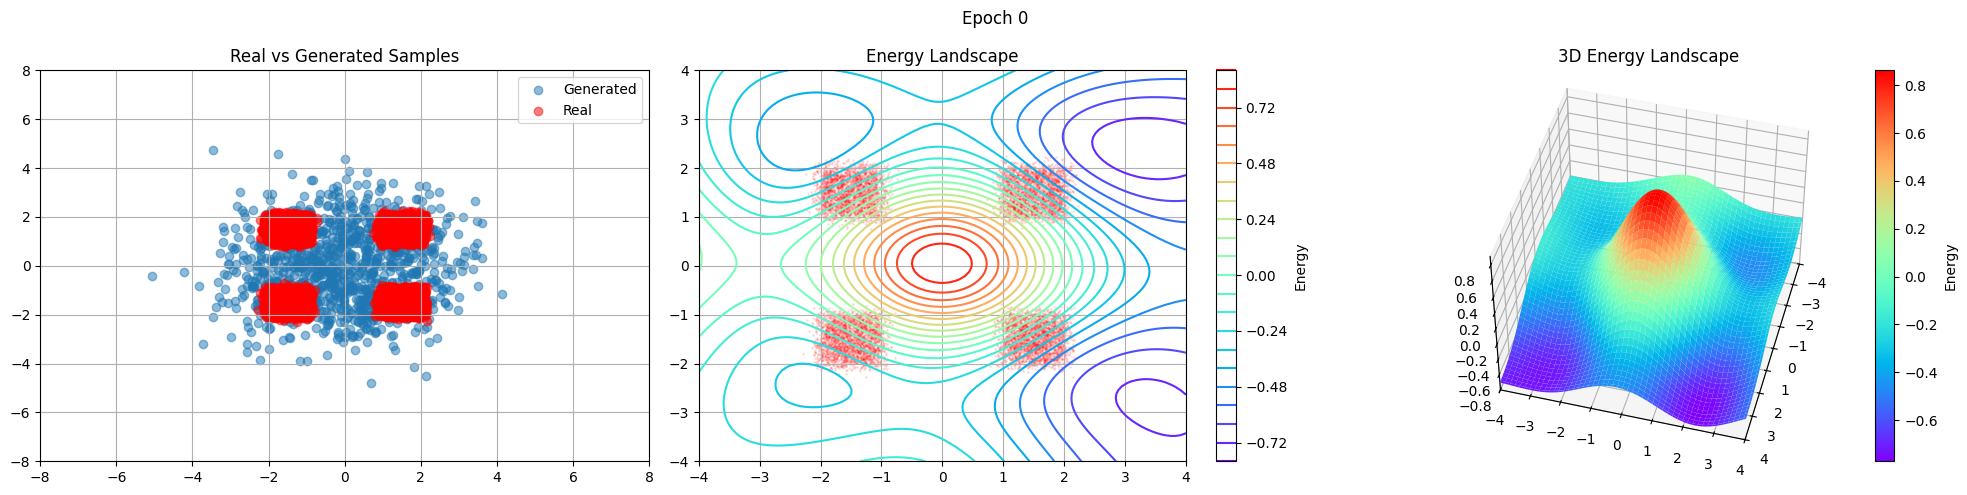

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: -0.39554196191481505


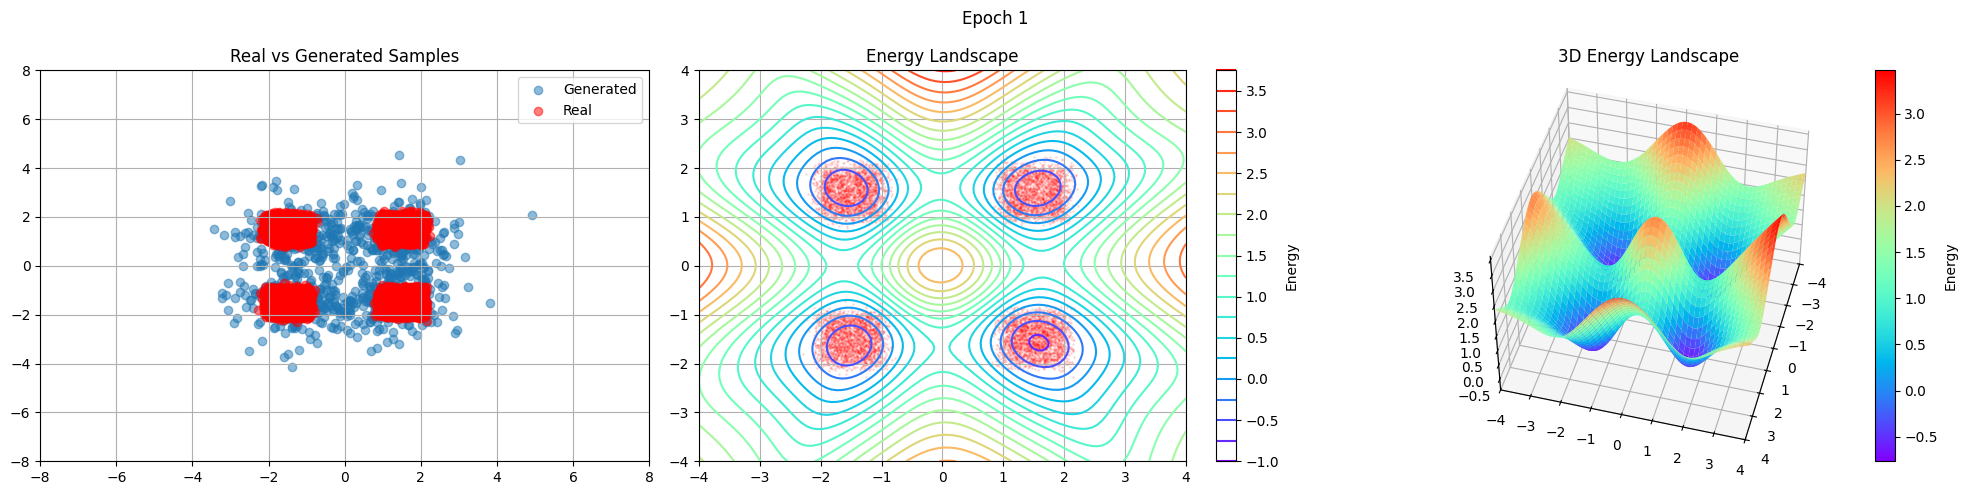

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: -0.44025015954773267


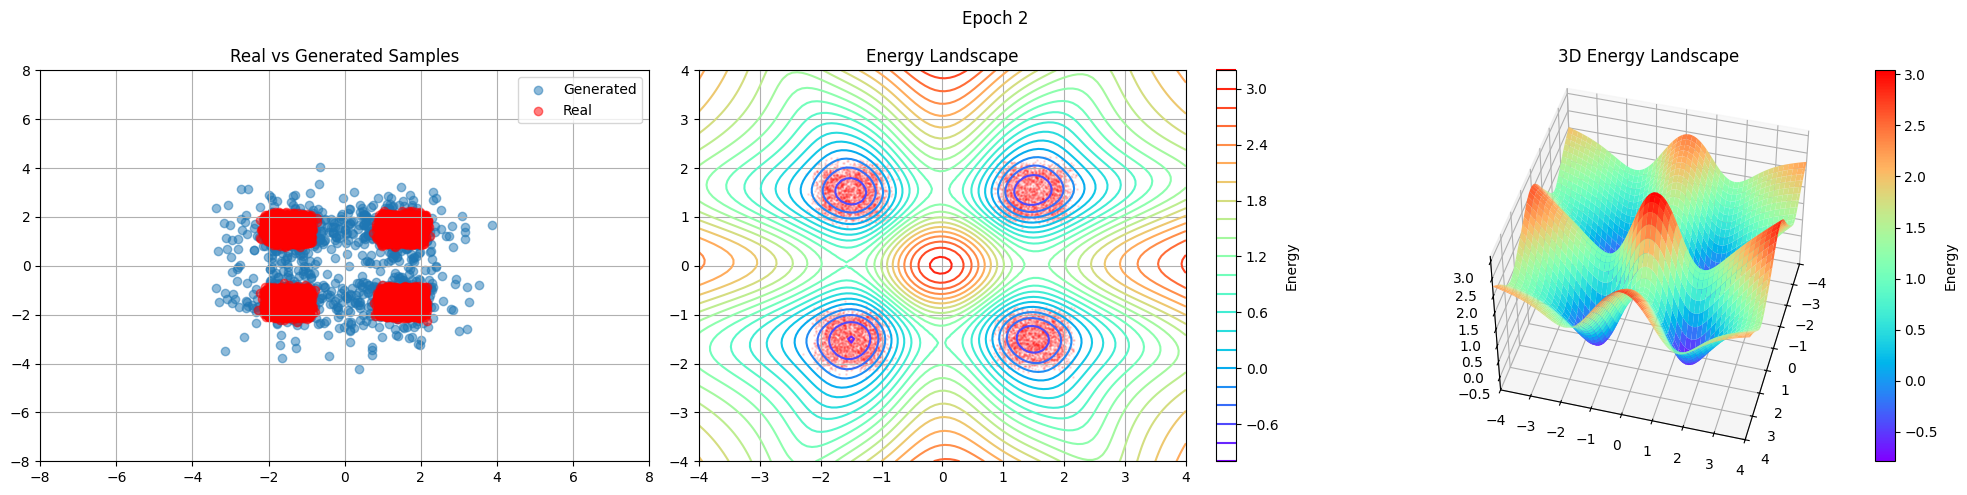

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: -0.43136630671473736


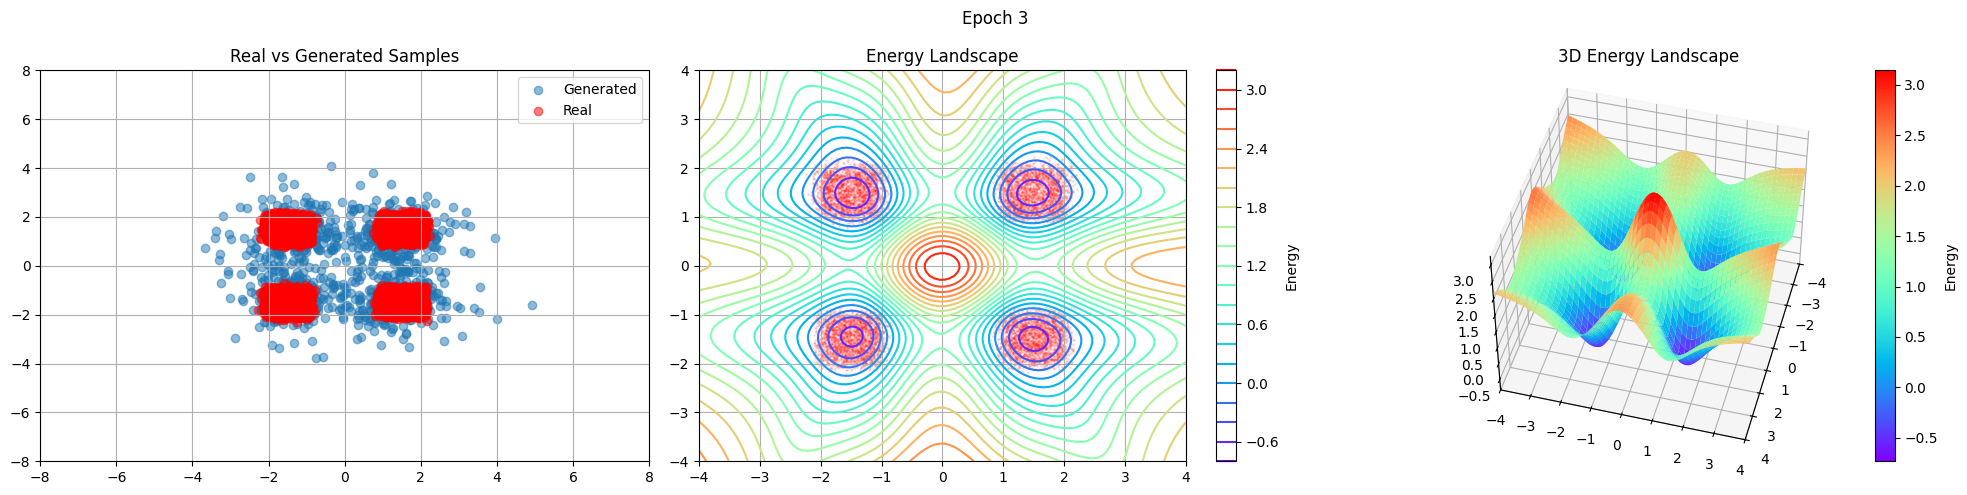

  0%|          | 0/313 [00:00<?, ?it/s]

In [9]:
num_epochs = 100
langevin_stepsize = 0.1
langevin_n_steps = 500
alpha = 0.4
buffer_size = 10000

model = MLP(in_dim=2, hidden_dim=32, out_dim=1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

replay_buffer = torch.randn(buffer_size, 2).cuda()

for epoch in range(num_epochs):
    l_loss = []
    for (pos_x,) in tqdm(train_data):
        pos_x = pos_x.cuda()

        buffer_idx = torch.randint(0, buffer_size, (pos_x.shape[0],))
        neg_x = replay_buffer[buffer_idx]
        # neg_x = sample_langevin(neg_x, model, langevin_stepsize, langevin_n_steps).cuda()
        neg_x = sample_hmc(
            neg_x,
            model,
            n_steps=50,  # Fewer steps needed than Langevin
            step_size=0.01,
            leapfrog_steps=10,
        )
        replay_buffer[buffer_idx] = neg_x.detach()

        optimizer.zero_grad()
        pos_out = model(pos_x.cuda())
        neg_out = model(neg_x.cuda())

        loss = (pos_out.mean() - neg_out.mean()) + alpha * (pos_out**2 + neg_out**2).mean()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        l_loss.append(loss.item())

    print(f"Epoch {epoch}: {np.mean(l_loss)}")
    visualize_samples(
        test_samples,
        # generate_samples(model, 1000, sampling_steps=3000, stepsize=0.01),
        generate_samples_hmc(model, 1000),
        model,
        title=f"Epoch {epoch}",
    )